# Setup

In [1]:
import json
import pprint
import numpy as np
from matplotlib import pyplot as plt
from contextlib import redirect_stdout
import io
import os
from pathlib import Path
from network_computation import compute_functional_network, compute_functional_network_th
from utilities_network import data_to_array_by_quantity, scale_data_array
from utilities_network import plot_network, SYMDICT, SENSOR_DICT
import utilities_visualization

In [2]:
SCALE_DATA = None # 'overall', 'individual', None
DISTANCE = 'recurrence' # 'threshold'
COMPUTE_NEW = True # To compute new networks
# FOLDER = "/Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/network-methods-code/2024-code-ExploringLocalizationInNonlinearOscillators/chrystal_rotation_results" # Save network data
FOLDER = "chrystal_rotation_results" # Save network data
os.makedirs(FOLDER, exist_ok=True)

# Data

Active slice of each quantity of each sensor.

- Inititally stored as a dictionary.
- First level: 5 sensors ('OR', 'OL', 'IB', 'IT', 'IL')
- Second level: 22 quantities ('time', 'ax', 'ay', 'az', 'phi', 'theta', 'psi', 'wx', 'wy', 'wz', 'phidot', 'thetadot', 'psidot', 'Ax', 'Ay', 'Az', 'dx', 'dy', 'dz', 'vx', 'vy', 'vz')

In [3]:
# Data was saved as a dictionary using experiment_save_data.py.
# To regenerate the data (use different experiment data or different active slice),
# Go to experiments directory and run in python:
    # python experiment_save_data.py

with open("../../experiments/data_2025-09-03 Euler Angles_20250903_203926.json", 'r') as f:
    data_dict = json.load(f)

if SCALE_DATA == 'overall':
    OUT_DIR = Path("plots/scaled_overall")
elif SCALE_DATA == 'individual':
    OUT_DIR = Path("plots/scaled_individually")
elif SCALE_DATA is None:
    OUT_DIR = Path("plots/no_scaling")

if DISTANCE == 'threshold':
    OUT_DIR = OUT_DIR/"th"
elif DISTANCE == 'recurrence':
    OUT_DIR = OUT_DIR/"rr"
    
if not OUT_DIR.exists():
    os.makedirs(OUT_DIR)

In [4]:
print("Data Dictionary Structure:")
print(f"{pprint.pformat(data_dict, depth=2)[:210]}\n...")
print(f"{len(list(data_dict['OR'].keys()))} Quantities Included:")
print([data_dict['OR'].keys()])

Data Dictionary Structure:
{'IB': {'Ax': [...],
        'Ay': [...],
        'Az': [...],
        'ax': [...],
        'ay': [...],
        'az': [...],
        'dx': [...],
        'dy': [...],
        'dz': [...],
        'phi': [...],
...
23 Quantities Included:
[dict_keys(['time', 'ax', 'ay', 'az', 'phi', 'theta', 'psi', 'wx', 'wy', 'wz', 'wxy', 'phidot', 'thetadot', 'psidot', 'Ax', 'Ay', 'Az', 'dx', 'dy', 'dz', 'vx', 'vy', 'vz'])]


## Incorporate Phase Space

Store the data as an array that is ready for `compute_functional_network`.

- The 3d array method allows each node to be a vector of multiple components (e.g., [dx,vx] or [t,wz]), so that phase space or multi-directional data can be used.

In [5]:
data = data_to_array_by_quantity(data_dict=data_dict,
                                         quantities={
                                            'OR':[['time','psidot']],
                                          #   'OR':[['time','wxy']],
                                            'IB':[['time','wx'], ['time','wy'], ['time','wz']],
                                            'IT':[['time','wx'], ['time','wy'], ['time','wz']],
                                            'IL':[['time','wx'], ['time','wy'], ['time','wz']],
                                         },
                                        )
print(f"{data.shape=}")

data.shape=(1894, 10, 2)


## Plot Data

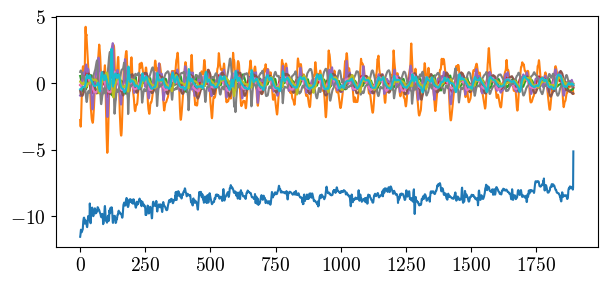

In [6]:
fig,ax = plt.subplots(figsize=(7,3))
ax.plot(data[:,:,1]);

# Network Analysis

- hoop, tibia, cuneiform, femur ('OR', 'IT', 'IL', 'IB')

## List Parameters for Networks

In [7]:
# Number of timesteps to analyze (first `N_TIME` timesteps will be used)
N_TIME = data.shape[0]

network_parameters = {
    'w_xy': dict(
        quantities={
            'OR':[['time','wxy']],
            'IB':[['time','wx'], ['time','wy'], ['time','wz']],
            'IT':[['time','wx'], ['time','wy'], ['time','wz']],
            'IL':[['time','wx'], ['time','wy'], ['time','wz']],
        },
        target_nodes = [f"{SYMDICT['wxy']},{SENSOR_DICT['OR']}"],
        width_scale=50.0,
        # optional thresholds and recurrence rates
        th=(0.1,0.1,0.05),
        rr=(0.03,0.03,0.02),
        C_threshold=0.02,
        T_threshold=0.02,
        verbose=True,
        diffs=True,
        draw_from_target_edges=False,
        draw_no_target_edges=False,
        sandwiched_couples=False,
        savez=False,
        save_data_array=True
    ),
    'psidot': dict(
        quantities={
            'OR':[['time','psidot']],
            'IB':[['time','wx'], ['time','wy'], ['time','wz']],
            'IT':[['time','wx'], ['time','wy'], ['time','wz']],
            'IL':[['time','wx'], ['time','wy'], ['time','wz']],
        },
        target_nodes = [f"{SYMDICT['psidot']},{SENSOR_DICT['OR']}"],
        width_scale=50.0,
        # optional thresholds and recurrence rates
        th=(0.1,0.1,0.05),
        rr=(0.03,0.03,0.02),
        C_threshold=0.02,
        T_threshold=0.02,
        verbose=True,
        diffs=True,
        draw_from_target_edges=False,
        draw_no_target_edges=False,
        sandwiched_couples=False,
        savez=False,
        save_data_array=True
    ),
}

## Run Networks

In [8]:
# For storing results
networks = {}
mappings = {}
target_node_lists = {}

In [9]:
def run_network(data_dict,title,verbose=True,**config):
    quantities = config['quantities']
    target_nodes = config['target_nodes']
    save_data_array = config.get('save_data_array',False)


    if SCALE_DATA is None:
        # Don't scale data at all
        data = data_to_array_by_quantity(data_dict,
                                quantities=quantities,
                                ntime=config.get('ntime',N_TIME))
        
    else:
        # Scale overall if specified; otherwise scale individually
        data = scale_data_array(data_to_array_by_quantity(data_dict,
                            quantities=quantities,
                            ntime=config.get('ntime',N_TIME)),
                            scale_overall=(SCALE_DATA=='overall'),
                            )
    if verbose:
        print(f"{title}: {data.shape=}")

    if save_data_array: # Save data array
        if verbose:
            print(f"Saving data array as {OUT_DIR}/{title}.npy")
        np.save(OUT_DIR/f"{title}.npy", data)
    
    with redirect_stdout(io.StringIO()): # suppress print statements
        if DISTANCE == 'threshold':
            network = compute_functional_network_th(data,
                                            config.get('th',(0.1,0.1,0.05)),
                                            n=config.get('n',np.shape(data)[1]),
                                            sandwiched_couples=config.get('sandwiched_couples',False),
                                            savez=config.get('savez',True),
                                            )
        elif DISTANCE == 'recurrence':

            network = compute_functional_network(data,
                                            config.get('rr',(0.06,0.06,0.02)),
                                            C_threshold=config.get('C_threshold',0.02),
                                            T_threshold=config.get('T_threshold',0.02),
                                            n=config.get('n',np.shape(data)[1]),
                                            sandwiched_couples=config.get('sandwiched_couples',False),
                                            savez=config.get('savez',True),
                                            )
            
            # Save data for chrystal / theresa comparison
            np.save(Path(FOLDER)/f"data_cc_{title}.npy", data)
    
    mapping = {}
    idx = 0
    for sensor,qsets in quantities.items():
        for qset in qsets:
            mapping[idx] = f"{SYMDICT[qset[-1]]},{SENSOR_DICT[sensor]}"
            idx += 1

    return network, mapping, target_nodes


In [10]:
if COMPUTE_NEW:
    if (OUT_DIR/'network_dictionaries.npz').exists() or False:
        print("Existing data found. Appending and Amending.")
        network_dictionaries = np.load(OUT_DIR/'network_dictionaries.npz',allow_pickle=True)
        networks = network_dictionaries['networks'].item()
        mappings = network_dictionaries['mappings'].item()
        target_node_lists = network_dictionaries['target_node_lists'].item()
        print(f"Existing configurations: {[title for title in networks.keys()]}")
        
    if DISTANCE == 'threshold':
        network_quantities = ['G', 'G_', 'common_G', 'C_xys', 'C_yxs', 'T_xys', 'T_yxs', 'rrx', 'rrxy']
    elif DISTANCE == 'recurrence':
        network_quantities = ['G', 'G_', 'common_G', 'T_diff', 'C_diff', 'C_xys', 'C_yxs', 'T_xys', 'T_yxs']

    for title,parameters in network_parameters.items():
        print(f"Now appending/amending configuration: {title}")
        network,mapping,target_nodes = run_network(data_dict,title,**parameters)

        networks[title] = {q: network[i] for i,q in enumerate(network_quantities)}
        mappings[title] = mapping
        target_node_lists[title] = target_nodes

    np.savez(OUT_DIR/'network_dictionaries.npz', networks=networks, mappings=mappings, target_node_lists=target_node_lists)
else:
    if (OUT_DIR/'network_dictionaries.npz').exists():
        print("Existing data found. Uploading.")
        network_dictionaries = np.load(OUT_DIR/'network_dictionaries.npz',allow_pickle=True)
        networks = network_dictionaries['networks'].item()
        mappings = network_dictionaries['mappings'].item()
        target_node_lists = network_dictionaries['target_node_lists'].item()
    else:
        print("No existing data found.")

Now appending/amending configuration: w_xy
w_xy: data.shape=(1894, 10, 2)
Saving data array as plots/no_scaling/rr/w_xy.npy
Now appending/amending configuration: psidot
psidot: data.shape=(1894, 10, 2)
Saving data array as plots/no_scaling/rr/psidot.npy


In [11]:
# Save Cxys, Txys for psidot

title = 'psidot'
np.save(os.path.join(FOLDER, "C_xys.npy"), networks[title]['C_xys'])
np.save(os.path.join(FOLDER, "T_yxs.npy"), networks[title]['T_yxs'])
np.save(os.path.join(FOLDER, "C_yxs.npy"), networks[title]['C_yxs'])
np.save(os.path.join(FOLDER, "T_xys.npy"), networks[title]['T_xys'])

## Plot Networks


w_xy:
mappings[title]={0: '$\\omega_{xy}$,h', 1: '$\\omega_{x}$,f', 2: '$\\omega_{y}$,f', 3: '$\\omega_{z}$,f', 4: '$\\omega_{x}$,t', 5: '$\\omega_{y}$,t', 6: '$\\omega_{z}$,t', 7: '$\\omega_{x}$,m', 8: '$\\omega_{y}$,m', 9: '$\\omega_{z}$,m'}
target_node_lists[title]=['$\\omega_{xy}$,h']

w_xy:
mappings[title]={0: '$\\omega_{xy}$,h', 1: '$\\omega_{x}$,f', 2: '$\\omega_{y}$,f', 3: '$\\omega_{z}$,f', 4: '$\\omega_{x}$,t', 5: '$\\omega_{y}$,t', 6: '$\\omega_{z}$,t', 7: '$\\omega_{x}$,m', 8: '$\\omega_{y}$,m', 9: '$\\omega_{z}$,m'}
target_node_lists[title]=['$\\omega_{xy}$,h']

psidot:
mappings[title]={0: '$\\dot{\\psi}$,h', 1: '$\\omega_{x}$,f', 2: '$\\omega_{y}$,f', 3: '$\\omega_{z}$,f', 4: '$\\omega_{x}$,t', 5: '$\\omega_{y}$,t', 6: '$\\omega_{z}$,t', 7: '$\\omega_{x}$,m', 8: '$\\omega_{y}$,m', 9: '$\\omega_{z}$,m'}
target_node_lists[title]=['$\\dot{\\psi}$,h']

psidot:
mappings[title]={0: '$\\dot{\\psi}$,h', 1: '$\\omega_{x}$,f', 2: '$\\omega_{y}$,f', 3: '$\\omega_{z}$,f', 4: '$\\ome

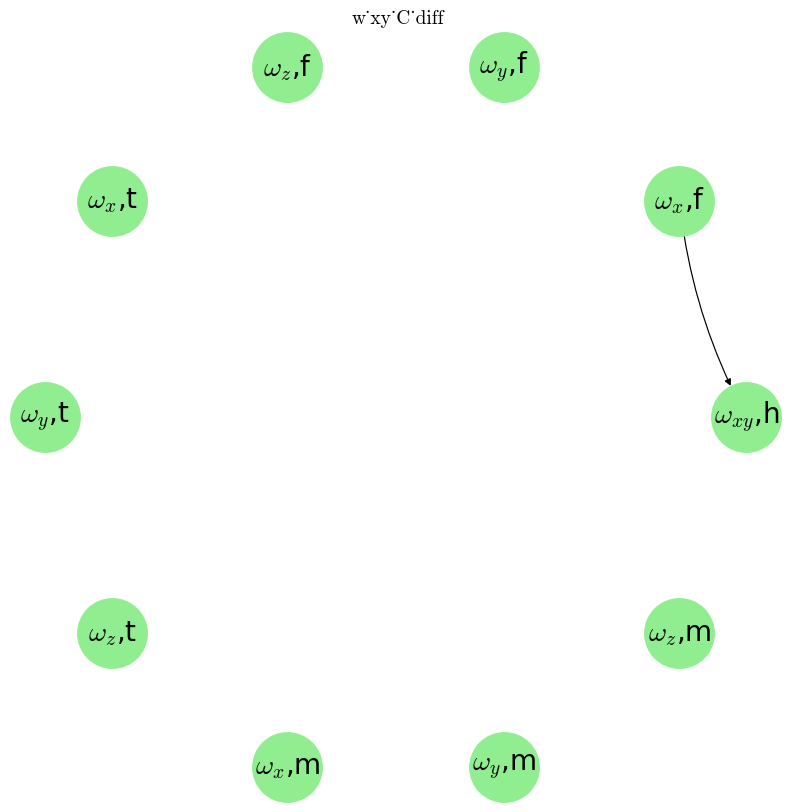

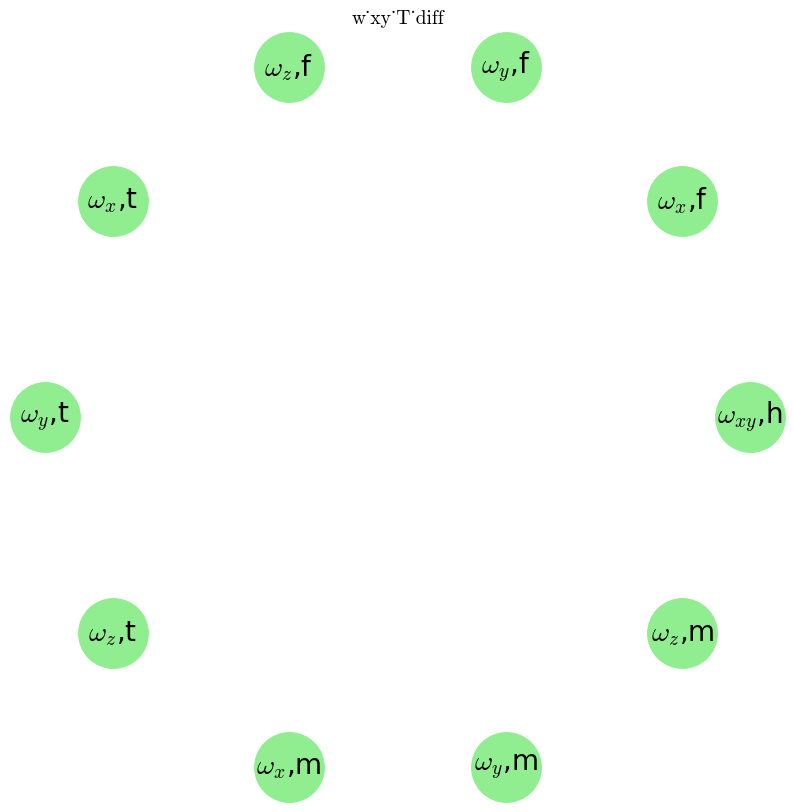

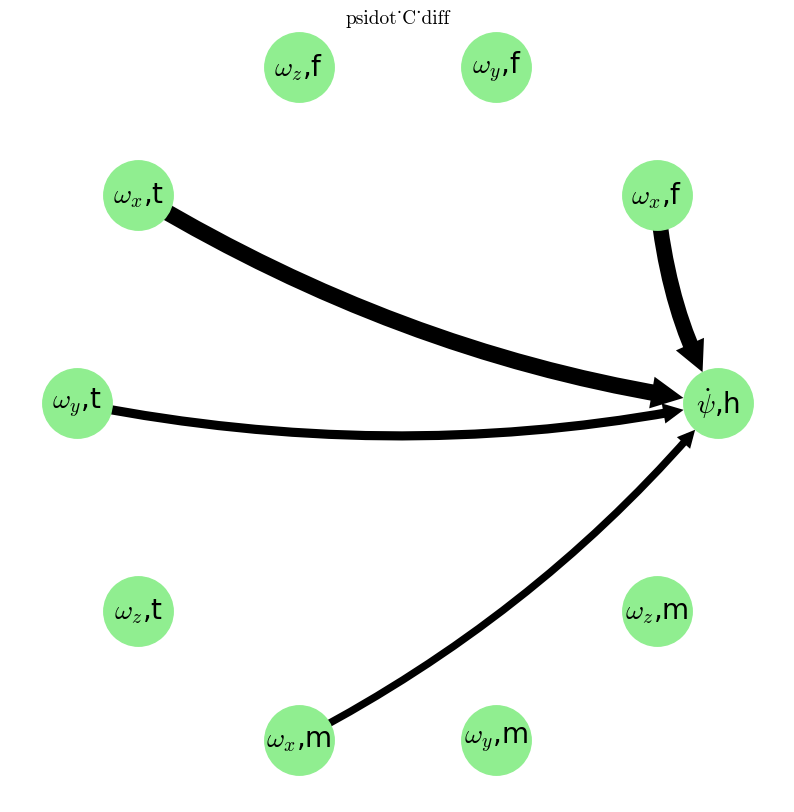

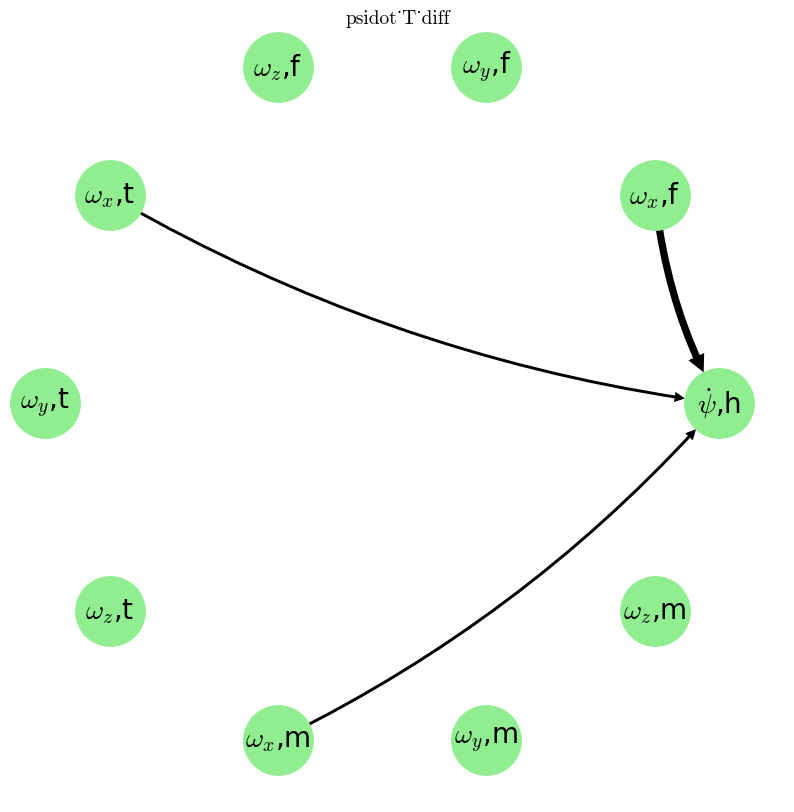

In [12]:
for title,parameters in network_parameters.items():
    for coeff_xy in ['C_xys','T_xys']:
        c_xy = networks[title][coeff_xy]
        diff_xy = c_xy-c_xy.T
        plot_title = f"{title}_{coeff_xy.replace('xys','diff')}"

        print(f"\n{title}:")
        print(f"{mappings[title]=}")
        print(f"{target_node_lists[title]=}")

        fig = plot_network(diff_xy,
                    mappings[title],
                    target_node_lists[title],
                    width_scale=parameters.get('width_scale',5.0),
                    diffs=parameters.get('diffs',False),
                    draw_from_target_edges=parameters.get('draw_from_target_edges',True),
                    draw_to_target_edges=parameters.get('draw_to_target_edges',True),
                    draw_no_target_edges=parameters.get('draw_no_target_edges',True),
                    title = plot_title)
        fig.savefig(OUT_DIR/f"{plot_title}.svg", dpi=400, transparent=True)
        fig.savefig(OUT_DIR/f"{plot_title}.png", dpi=400, transparent=True)